# Basis embedding (pennylane)

Main steps:

* initialize an image of the sky (frequency domain)
* apply 2D FT --> visibilities (Fourier domain)
* encode visibilities data into qubits using amplitude embedding (non-conventional domain)
* measure qubits on simulator --> expected outcomes (back to conventional domain)
* apply 2D IFT --> fidelity computation

Basis embedding:

* from https://docs.pennylane.ai/en/stable/code/api/pennylane.BasisEmbedding.html
* literature: https://hillside.net/plop/2020/papers/weigold.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct

import pennylane as qml
from pennylane import numpy as pnp

### Prerequisites

In [2]:
# float to binary 
def float_to_bin_real(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')
def float_to_bin_imag(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')

# binary to float
def bin_to_float_real(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]
def bin_to_float_imag(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]

## 1) Generating an artificial image of the sky (frequency domain)

In [3]:
#image of the sky filled with double precision complex floats ('complex64')
#pixels are set to low complex random values (image background/noise) 
#few pixels are set to larger complex random values in a specified ellipse area (image source/subject)
n = 10 #20
sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
number_of_stars = np.random.randint(3, 11)
radius = np.random.randint(1, 3)

for i in range(0, number_of_stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[ 5.6622345e-03+6.77522225e-03j  6.8021758e-04+9.32586659e-03j
  -3.7889394e-03+2.80926260e-03j  6.1393414e+01+8.14401531e+00j
   1.9869662e-03-2.13948451e-02j -2.0478482e-03-1.64958313e-02j
   1.1224177e-02-1.42890457e-02j  5.1469300e-03-2.32168147e-03j
  -1.5632289e-02-1.91560499e-02j -5.1635057e-03-4.40850900e-03j]
 [-7.1028559e-03-1.10338740e-02j -4.1071582e-03+1.51233450e-02j
  -1.5167798e-02-1.73813407e-03j -1.3598283e-02-3.89357936e-03j
   1.7435705e-02+2.00421195e-02j  5.9414772e+01+6.71427612e+01j
   1.4949139e-02+2.19756039e-03j -1.3939207e-02-2.47657951e-03j
   1.4594443e-02-7.40341237e-03j -6.4117429e-03+4.06338647e-03j]
 [-5.4500955e-03+3.27111385e-03j  7.4222535e-03+3.27955908e-03j
  -4.4280649e-03-2.71119513e-02j  4.5804805e-03-2.88866460e-03j
  -1.2371549e-03+9.63141560e-04j  8.5931933e-03+1.39449351e-02j
  -1.9568710e-03-8.57281499e-03j  9.7258110e+01+8.30566692e+00j
  -2.2889287e-04-2.41841096e-03j -4.0749353e-03+1.01239905e-02j]
 [-2.3593010e-02+5.35332086e-03j  3.3

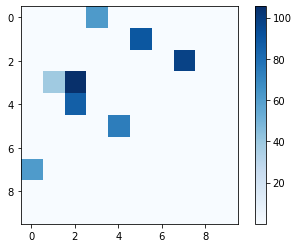

In [4]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

## 2) Applying a 2D FT (Fourier domain)

In [5]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 5.2121075e+02+250.34808j    9.0752884e+01-203.177j
  -6.4291222e+01 -60.9527j     1.9413639e+01-128.24171j
   3.7128223e+01+264.664j      1.7289974e+01 +44.42118j
   2.3022467e+02-118.47514j    1.5612500e+01 -73.96637j
  -1.3436304e+02 +98.04195j   -1.4746739e+02+123.18233j  ]
 [ 8.9965019e+01-227.4102j    -1.8182835e+02 +27.613943j
  -1.8213492e+02+172.33246j   -1.1108002e+02+140.14565j
   3.4984070e+02  -6.0435843j -2.9961575e+02 -26.371725j
  -9.9752113e+01+131.29637j   -1.3511414e+01 +12.340539j
   9.6143417e+01+275.32605j   -1.5376685e+01  -2.0651634j]
 [-1.8445488e+01 -49.986797j  -8.0428627e+01 -78.96198j
   8.1175819e+01+153.98389j   -6.5293381e+01 -78.6979j
   4.2348910e-02-263.93277j   -8.0464027e+01+124.42413j
  -2.8095517e+00 +19.648338j  -2.7528555e+00 -99.78988j
   1.7151147e+02-290.2106j    -3.6152719e+02 +60.65258j  ]
 [ 6.4127502e+01 -15.10064j    7.5557846e+01 -30.125853j
   1.9344962e+02-171.862j     -4.5087952e+01+210.91908j
   1.2445664e+02-224.81181j   -1.46563

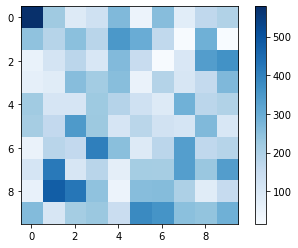

In [6]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

### Sanity check

In [7]:
img = np.fft.ifft2(visibilities).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: ' + str(test_imag))

Reals MSE: 1.7696477e-13
Imaginaries MSE: 1.5393183e-13


## 3) Data encoding: basis embedding (non-conventional domain)

In [8]:
# vectorize input data
data = visibilities.flatten()

# get binary representations of real and imaginary parts
data_reals = []
data_imags = []
for i in range(0, len(data)):
    data_reals.append(float_to_bin_real(data[i].real))
    data_imags.append(float_to_bin_imag(data[i].imag))

# combine binary representations into a single array (reals then imaginaries)
data_binaries = data_reals + data_imags 

# sparse all binary representations strings into single characters
data_binary = []
for i in range(0, len(data_binaries)):
    data_binary.append([*data_binaries[i]])

# get rid of generated sub-arrays
inp = []
for i in range(0, len(data_binary)):
    inp += data_binary[i]

# make all character-strings integers
ini = []
for i in range(0, len(inp)):
    ini.append(int(inp[i]))

# n bits encoded onto n quibts
wires = range(len(ini)) 
bas_dev = qml.device('default.qubit', wires) # simulator (MOTIVATION?)

# encoding
@qml.qnode(bas_dev)
def basis_encoding(data):
    qml.BasisEmbedding(data, wires)
    return qml.state

readout = basis_encoding(ini)
print(readout)

ValueError: Maximum allowed dimension exceeded

## 4) Applying 2D IFT (fidelity test)

In [ ]:
img = np.fft.ifft2(readout).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(img)
modulus2 = np.absolute(sky_image)

axs[0].imshow(modulus1, cmap='Blues')
axs[1].imshow(modulus2, cmap='Blues')

axs[0].set_title("Reconstructed image")
axs[1].set_title("Original image")

for ax in axs.flat:
    ax.set(xlabel='n', ylabel='n')